

# $\color{green}{\text{ 10.4. Neighborhood-Based Collaborative Filtering }}$

-------



### $\color{green}{\text{Agenda : }}$


 - What is collaborative filtering?
 - Cosine Similarity
 - User based filtering
 - Creating recommendations
 - Adding new users

------

* ##   What is Collaborative Filtering?

In the context of e.g. recommendations engines, it is the process of **inferring the taste of one user, based on the knowledge of the tastes of other users**.

**Types of collaborative filtering:**

* _neigbourhood-based_ (also, _memory-based_):
    * **user-based**: looks for similarities in ratings between the target user and other users; _user-item matrix_
    * **item-based**: looks for similarities in items the target user has rated and other users have rated; _item-item matrix_
* _model-based_:
    * e.g. NMF

-----

* ## What do we mean by *neighbourhood*?

How do we measure **similarity** or **proximity** of two objects? - see references below for other measures. Today we focus on:

### Cosine Similarity

- **Angle** measurement between two vectors. **Orientation**, not magnitude.
- Values range between:
  
    `-1`: vectors point in opposite directions.
  
    `+1`: vectors are on top of each other.
    
     `0`: vectors are perpendicular. 

$$cos(x, y) = \dfrac{\textbf{x} \cdot \textbf{y}}{\lVert \textbf{x} \rVert \lVert \textbf{y} \rVert}= \dfrac{\sum_i^n{x_i*y_i}}{\sqrt{\sum_i^n{x_i^2}}\sqrt{\sum_i^n{y_i^2}}}$$

Numerator: dot product of the vectors

Denominator: Euclidean norms (=lengths) of the vectors multiplied

An additional option is to use the **adjusted** or **centred** cosine similarity, which subtracts each user's average rating from all their ratings (mean=0). 

### User-vectors

We can think of the rows of our ratings as being vectors, one for each user. Then we can use the cosine similarity as a measure of how "close" or "far apart" their tastes are by running the above calculation between two users

-----

## Example with your movie ratings

In [2]:
import numpy as np
import pandas  as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity

In [3]:
R = pd.read_csv('cohort_rated_movies.csv', index_col=0)

In [4]:
R.sample(5)

,Forrest Gump,Shawshank Redemption,Pulp Fiction,Silence of the Lambs,"Matrix, The",Star Wars: Episode IV,Jurassic Park,Braveheart,Terminator 2,Toy Story,American Beauty,Dances with Wolves,Lord of The Rings Trilogy,Lion King
User,,,,,,,,,,,,,,
Hakan,5,5.0,5.0,5.0,5,3.0,2,5.0,4.0,3.0,5.0,5.0,4,2
Dalal,4,4.0,5.0,5.0,5,4.0,4,4.0,NaN,2.0,5.0,NaN,5,4
Ahmed,5,5.0,4.0,3.0,5,2.0,2,1.0,4.0,5.0,4.0,NaN,5,5
Siamak,5,NaN,5.0,5.0,2,2.0,1,NaN,3.0,2.0,3.0,NaN,2,4
alex,5,5.0,4.0,4.0,5,NaN,3,3.0,2.0,3.0,4.0,4.0,4,3


We have to deal with the `NaN`s. Remember we have some options available:

- global average
- 0
- average of each user
- average of the movie
- ...

For cosine similarity we need to fill the `NaN`s with zero because we don't want imputed means making users seem similar when they are not

In [8]:
# impute the nan with 0:
R = R.fillna(value=0)
R.sample(5)


,Forrest Gump,Shawshank Redemption,Pulp Fiction,Silence of the Lambs,"Matrix, The",Star Wars: Episode IV,Jurassic Park,Braveheart,Terminator 2,Toy Story,American Beauty,Dances with Wolves,Lord of The Rings Trilogy,Lion King
User,,,,,,,,,,,,,,
Dalal,4,4.0,5.0,5.0,5,4.0,4,4.0,0.0,2.0,5.0,0.0,5,4
Shea,4,5.0,5.0,5.0,4,2.0,3,3.0,4.0,3.0,4.0,2.0,3,3
Gülcin,5,5.0,5.0,5.0,4,5.0,3,2.0,2.0,0.0,5.0,0.0,4,3
Siamak,5,0.0,5.0,5.0,2,2.0,1,0.0,3.0,2.0,3.0,0.0,2,4
Manuel,4,4.0,5.0,3.0,3,3.0,3,3.0,3.0,3.0,5.0,4.0,3,2


### Calculate Cosine-similarities between users

- Numerator: dot products of the vectors
- Denominator: Euclidean norm of the vectors multiplied

In [9]:
def cos_sim(vec1, vec2):
    """function to calcualte the cosine similarity between two vectors""" 
    num = np.dot(vec1, vec2)
    denom = np.sqrt(np.dot(vec1, vec1)) * np.sqrt(np.dot(vec2, vec2))
    return num / denom

We can take two user vectors and compare them:

In [10]:
# define two users-vectors
user_1 = R.loc['Gülcin']
user_2 = R.loc['Jenny']


In [11]:
# calculate cosine similarity

cos_sim(user_1,user_2)

0.7484943275900947

-----

### User-based filtering 
"*Users similar to you also enjoyed X and Y*"

#### Create a table with pairwise user/user cosine-similarities
* We can write a function that takes ratings matrix as an argument and in the nested loop finds the cosine similarities between user pairs.

In [12]:
R.index

Index(['Ahmed', 'Jenny', 'Sima', 'Gülcin', 'Shea', 'Dalal', 'Maisam', 'Media',
       'alex', 'Hakan', 'Manuel', 'Nara', 'Siamak', 'Md Najrul'],
      dtype='object', name='User')

In [16]:
def cos_sim_table(R):
    data = []
    for user1 in R.index:
        row = []
        for user2 in R.index:
            cs = cos_sim(R.loc[user1],R.loc[user2])
            row.append(cs)
        data.append(row)
    table = pd.DataFrame(data,index=R.index, columns=R.index)
    return table

In [17]:
cosine_similarity_table = cos_sim_table(R)
cosine_similarity_table

User,Ahmed,Jenny,Sima,Gülcin,Shea,Dalal,Maisam,Media,alex,Hakan,Manuel,Nara,Siamak,Md Najrul
User,,,,,,,,,,,,,,
Ahmed,1.000000,0.851662,0.955734,0.877515,0.932988,0.884538,0.878021,0.890160,0.906293,0.872631,0.882053,0.821127,0.848625,0.856450
Jenny,0.851662,1.000000,0.812261,0.748494,0.879427,0.794719,0.845463,0.798566,0.886864,0.869972,0.913754,0.746336,0.713892,0.914831
Sima,0.955734,0.812261,1.000000,0.883673,0.949425,0.858770,0.874726,0.864007,0.888120,0.891552,0.898632,0.760008,0.866789,0.858038
Gülcin,0.877515,0.748494,0.883673,1.000000,0.925741,0.956858,0.813406,0.857936,0.863973,0.889254,0.898855,0.713714,0.846260,0.863814
Shea,0.932988,0.879427,0.949425,0.925741,1.000000,0.918949,0.901402,0.875905,0.956101,0.966002,0.962914,0.768473,0.855098,0.931695
Dalal,0.884538,0.794719,0.858770,0.956858,0.918949,1.000000,0.851081,0.908954,0.892757,0.888204,0.894556,0.769042,0.813662,0.856360
Maisam,0.878021,0.845463,0.874726,0.813406,0.901402,0.851081,1.000000,0.946295,0.899383,0.906490,0.915490,0.802158,0.903696,0.859690
Media,0.890160,0.798566,0.864007,0.857936,0.875905,0.908954,0.946295,1.000000,0.852210,0.839022,0.860350,0.804235,0.926778,0.778346
alex,0.906293,0.886864,0.888120,0.863973,0.956101,0.892757,0.899383,0.852210,1.000000,0.958542,0.944620,0.743476,0.778318,0.929123


<AxesSubplot:xlabel='User', ylabel='User'>

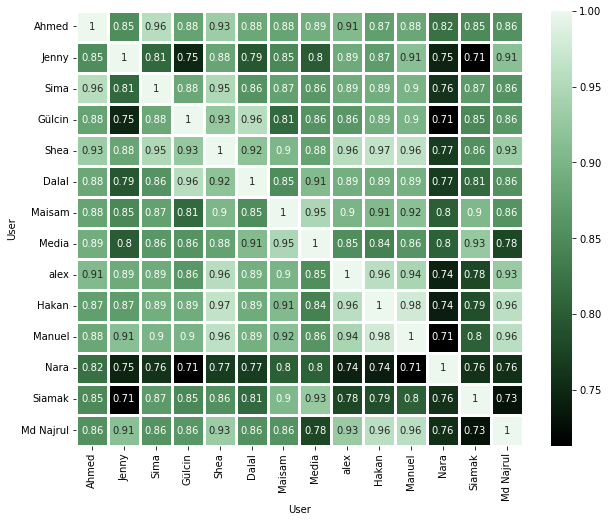

In [21]:
#Can display the table as a heatmap: 
plt.figure(figsize=(10,8))
sns.heatmap(cosine_similarity_table, annot=True, linewidth = 3, cmap =sns.cubehelix_palette(start=2,rot=0,dark=0, light=.95, reverse=True,as_cmap=True), xticklabels = cosine_similarity_table.index,
yticklabels=cosine_similarity_table.index)

### One-liner from  `sklearn`

In [22]:
from sklearn.metrics.pairwise import cosine_similarity

In [23]:
# Returns numpy array:
cosine_similarity(R)


array([[1.        , 0.85166246, 0.95573432, 0.8775147 , 0.93298811,
        0.88453796, 0.87802136, 0.89016041, 0.90629329, 0.87263071,
        0.88205286, 0.8211267 , 0.84862513, 0.8564502 ],
       [0.85166246, 1.        , 0.81226138, 0.74849433, 0.87942698,
        0.79471941, 0.8454631 , 0.79856647, 0.8868637 , 0.86997181,
        0.9137541 , 0.74633608, 0.71389226, 0.9148307 ],
       [0.95573432, 0.81226138, 1.        , 0.88367277, 0.94942533,
        0.85876985, 0.87472649, 0.86400696, 0.88811963, 0.8915519 ,
        0.89863158, 0.76000833, 0.86678876, 0.85803758],
       [0.8775147 , 0.74849433, 0.88367277, 1.        , 0.92574089,
        0.95685784, 0.81340644, 0.85793631, 0.86397321, 0.88925374,
        0.89885537, 0.7137144 , 0.84625964, 0.86381357],
       [0.93298811, 0.87942698, 0.94942533, 0.92574089, 1.        ,
        0.91894918, 0.90140158, 0.87590533, 0.95610108, 0.96600193,
        0.96291384, 0.76847328, 0.85509773, 0.93169499],
       [0.88453796, 0.79471941, 0.8

In [28]:
# We can turn this into a dataframe:
cos_sim_table = pd.DataFrame(cosine_similarity(R),index=R.index, columns = R.index)
cos_sim_table

User,Ahmed,Jenny,Sima,Gülcin,Shea,Dalal,Maisam,Media,alex,Hakan,Manuel,Nara,Siamak,Md Najrul
User,,,,,,,,,,,,,,
Ahmed,1.000000,0.851662,0.955734,0.877515,0.932988,0.884538,0.878021,0.890160,0.906293,0.872631,0.882053,0.821127,0.848625,0.856450
Jenny,0.851662,1.000000,0.812261,0.748494,0.879427,0.794719,0.845463,0.798566,0.886864,0.869972,0.913754,0.746336,0.713892,0.914831
Sima,0.955734,0.812261,1.000000,0.883673,0.949425,0.858770,0.874726,0.864007,0.888120,0.891552,0.898632,0.760008,0.866789,0.858038
Gülcin,0.877515,0.748494,0.883673,1.000000,0.925741,0.956858,0.813406,0.857936,0.863973,0.889254,0.898855,0.713714,0.846260,0.863814
Shea,0.932988,0.879427,0.949425,0.925741,1.000000,0.918949,0.901402,0.875905,0.956101,0.966002,0.962914,0.768473,0.855098,0.931695
Dalal,0.884538,0.794719,0.858770,0.956858,0.918949,1.000000,0.851081,0.908954,0.892757,0.888204,0.894556,0.769042,0.813662,0.856360
Maisam,0.878021,0.845463,0.874726,0.813406,0.901402,0.851081,1.000000,0.946295,0.899383,0.906490,0.915490,0.802158,0.903696,0.859690
Media,0.890160,0.798566,0.864007,0.857936,0.875905,0.908954,0.946295,1.000000,0.852210,0.839022,0.860350,0.804235,0.926778,0.778346
alex,0.906293,0.886864,0.888120,0.863973,0.956101,0.892757,0.899383,0.852210,1.000000,0.958542,0.944620,0.743476,0.778318,0.929123


In [ ]:
plt.figure(figsize=(10,8))
sns.heatmap(cosine_similarity(R), annot=True, linewidths = 3, 
            cmap=sns.cubehelix_palette(start=2, rot=0, dark=0, light=.95, reverse = True, as_cmap=True) ,
           xticklabels=cosine_similarity_table.index,
           yticklabels=cosine_similarity_table.index);  

------

## Coffee break 15min! ☕

-----

### How do we create recommendations based on this result?

**Algorithm**

Define active user:
- create a list of unseen movies for the active user
- get the nearest neighbours users (most similar users)
- for each unseen movie: 
    - get the neighbours who have rated/seen the movie 
    - predict the ratings based on the (weighted) average ratings of the neighbours
- collect all unseen movies sorted by predicted ratings. Give Top X as prediction.

(This can all be done by writing for-loops and comparing values.)

In [ ]:
# use the transposed version of R


In [ ]:
# choose an active user


In [ ]:
# create a list of unseen movies for this user


In [ ]:
# Create a list of top 3 similar user (nearest neighbours)


In [ ]:
# create the recommendation (predicted/rated movie)
predicted_ratings_movies = []

for movie in unseen_movies:
    
    # we check the users who watched the movie
    people_who_have_seen_the_movie = list(R_t.columns[R_t.loc[movie] > 0])
    
    num = 0
    den = 0
    for user in neighbours:
        # if this person has seen the movie
        if user in people_who_have_seen_the_movie:
        #  we want extract the ratings and similarities
            rating = R_t.loc[movie,user]
            similarity = cosine_sim_table.loc[active_user,user]
            
        # predict the rating based on the (weighted) average ratings of the neighbours
        # sum(ratings)/no.users OR 
        # sum(ratings*similarity)/sum(similarities)
            num = num + rating*similarity
            den = den + similarity
    predicted_ratings = num/den
    predicted_ratings_movies.append([predicted_ratings,movie])

In [ ]:
# create df pred


### What happens if a new user joins?

In [ ]:
# initialize new user 


In [ ]:
ratings = {'Forrest Gump': ,
 'Shawshank Redemption': ,         
 'Matrix': ,
 'Star Wars: Episode IV':,               
 'Pulp Fiction': ,
  'Lord of The Rings Trilogy': }

In [ ]:
# new user dataframe



#### Advantages of Neighbourhood Bases approaches

      * Fast
      * Works for huge datasets
      * No domain knowledge necessary

#### Disadvantages

      * Hard to include other data than ratings
      * Sparsity
      * Cold start problem

### Other good measure of similarity

Check also the Adjusted Cosine Similarity that calcaulates normalized distances taking care of grumpy or happy users

------

### Bonus: Item based filtering 
"*Because you watched X, you may also enjoy Y*"

Item-based filtering can be done in a similar way - see [course material](https://spiced.space/costmary-function/ds-course/chapters/project_movie_recommender/neighborhood_based_cf.html)

------

## Next steps:

#### Neighborhood based recommender function

- Collect different example queries for "typical" users (e.g. a horror movie buff, a Disney Person) and try out the algorithm
- Set the number of neighbors to a very high or low number. What happens to the recommendations?
- Implement a recommender function that recommends movies to a new user based on the NearestNeighbor model!


#### ⭐ Further Experiments:
- Try out *other distance metrics*: Convert the rating matrix into a *boolean matrix* (rated:1 vs not-rated:0) and use the *Jaccard similarity*.
- Use the adjusted cosine similarity, does it make a difference?
- Try out another method for calculating the score: use a *weighted* (weights = distances) sum or average. 
- Find similar *movies*! Use the method to find and recommend similar movies! Hint: Run the model on the *transposed* user item rating matrix.

## References/ Further reading:

- [A guide to distance measures from `SciPy`](https://docs.scipy.org/doc/scipy/reference/spatial.distance.html)
- [NMF and cosine similarity](https://colab.research.google.com/github/ML-Challenge/week4-unsupervised-learning/blob/master/L4.Discovering%20interpretable%20features.ipynb#scrollTo=hxYA_Dasi1tp) notebook on Google Colab